# Tech Challenge - Fase 4 - Modelo Preditivo do Preço do Petróleo + Plano Deploy
**Aluno:** Beatriz Rosa Carneiro Gomes -
**RM:** 357905 - **Turma**: 6DTAT


Este projeto tem como objetivo explorar os dados do petróleo por meio da análise de séries temporais e da comparação de diferentes modelos preditivos para prever seu preço. O modelo com melhor desempenho será implantado em produção via Streamlit, junto a um dashboard interativo que apresentará insights sobre a variação dos preços, considerando fatores como geopolítica, crises econômicas e demanda global. Após a seleção do modelo ideal, será desenvolvido um plano de deploy para garantir sua disponibilização e manutenção em produção.

# 1. Bibliotecas

1.1 Importação de Bibliotecas:
Segue abaixo as bibliotecas que serão usadas e suas principais funcionalidades:
- matplotlib: Usada para criar gráficos e visualizações.
- numpy: Utilizada para manipulação de arrays e operações matemáticas.
- pandas: Utilizada para manipulação e análise de dados.
- statsmodels: Fornece ferramentas para análise estatística e econometria.
- xgboost: Algoritmo eficiente de boosting, comumente usado para problemas de machine learning.
- yfinance: Biblioteca para baixar dados financeiros, como o usado para coletar o Ibovespa.
- pmdarima: Focada em modelagem de séries temporais, especialmente para automação de ARIMA.
- prophet: Modelo desenvolvido pelo Facebook para previsão de séries temporais.
- sklearn (scikit-learn): Biblioteca fundamental para machine learning.

In [ ]:
#!pip install matplotlib==3.3.4
#!pip install numpy==1.22.4
#!pip install pandas==2.0.3
#!pip install statsmodels==0.14.1
#!pip install xgboost==2.1.1
#!pip install yfinance==0.2.44
#!pip install pmdarima==2.0.4
#!pip install prophet==1.1.6
#!pip install scikit-learn==0.24.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 53.6 MB/s eta 0:00:00


In [ ]:
#%pip freeze > requirements_jp.txt


Note: you may need to restart the kernel to use updated packages.


In [68]:
import matplotlib
import numpy
import pandas
import statsmodels
import xgboost
import yfinance
import pmdarima
import prophet
import sklearn
import plotly.graph_objects

print(f"""
-- Versões Bibliotecas --
matplotlib: {matplotlib.__version__}   numpy: {numpy.__version__}
pandas: {pandas.__version__}   statsmodels: {statsmodels.__version__}
xgboost: {xgboost.__version__}   yfinance: {yfinance.__version__}
pmdarima: {pmdarima.__version__}   prophet: {prophet.__version__}
sklearn: {sklearn.__version__}
""")



-- Versões Bibliotecas --
matplotlib: 3.3.4   numpy: 1.22.4
pandas: 2.0.3   statsmodels: 0.14.1
xgboost: 2.1.1   yfinance: 0.2.44
pmdarima: 2.0.4   prophet: 1.1.6
sklearn: 0.24.1



In [70]:
# Renomeando bibliotecas para facilitar uso
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import xgboost as xgb
import yfinance as yf
import pmdarima as pm
import plotly.graph_objects as go

from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf as _plot_acf
from statsmodels.graphics.tsaplots import plot_pacf as _plot_pacf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
)
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score

In [71]:
# Ignorando mensagens de atenção
import warnings
from pandas.errors import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore")

# 2. Definindo Métricas para Avaliação de Modelos

Abaixo será definido uma função com intuito de facilitar o cálculo das métricas de avaliação de cada modelo, dessa forma será possível determinar qual modelo apresentou melhor desempenho.
Para fins de avaliação será usado o MAE, MSE e MAPE:
- MAE (Mean Absolute Error): Calcula o erro absoluto médio entre os valores reais e previsões, assim será possível entender o quanto as previsões estão distantes dos valores reais.Quanto menor o MAE, mais preciso é o modelo.

- MSE (Mean Squared Error): Calcula o erro quadrático médio, aqui quanto maior o erro, maior será o impacto no cálculo, pois os grandes erros são mais penalizados com as diferenças as quadrado.

- MAPE (Mean Absolute Percentage Error): Calcula a diferença entre os valores reais e os valores previstos, expressando o erro como uma porcentagem dos valores reais. Valores menores de MAPE indicam que o modelo de previsão é mais preciso, enquanto valores maiores indicam menos precisão. Por exemplo, um MAPE de 5% significa que, em média, as previsões estão 5% distantes dos valores reais.

In [72]:
# Função para calcular métricas de avaliação

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    r2 = r2_score(y_true, y_pred)  # Calculando o R²
    return mae, mse, mape, r2

# Função para imprimir as métricas de avaliação
def print_metrics(metrics):

    mae, mse, mape, accuracy = metrics

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"MAPE: {mape:.2f} %")
    print(f"Acurácia: {accuracy:.2f} %")

# 3. Importação dos Dados

Nesta etapa, serão importados dados históricos da bolsa de valores usando a biblioteca yfinance, desde 02/01/1994 até 10/10/2024. Serão selecionados apenas os dados mais relevantes, como data, valores de abertura e fechamento, para focar na análise das variações diárias do mercado.

In [73]:
# Baixando os dados do Ibovespa
ticker = "BZ=F"
data = yf.download(ticker, start="1994-01-02", end="2025-02-10")
data = data[["Open", "Close"]] #Selecionando apenas os valores de abertura e fechamento
data.reset_index(inplace=True)
data["Date"] = pd.to_datetime(data["Date"])

[*********************100%***********************]  1 of 1 completed


# 4. Análise Exploratória (EDA)

A seguir, será realizada a análise exploratória dos dados, começando pela verificação dos tipos de dados e a identificação de valores ausentes ou duplicados, que, caso existam, serão excluídos para não comprometer a análise. Em seguida, será apresentada uma descrição resumida dos dados, além da análise de outliers e da variação dos valores desde 2007.

In [74]:
# Visualizando os primeiros registros
print("Primeiros dados:")
data.head()

Primeiros dados:


Date       Open      Close
0 2007-07-30  75.849998  75.739998
1 2007-07-31  75.699997  77.050003
2 2007-08-01  77.000000  75.349998
3 2007-08-02  75.220001  75.760002
4 2007-08-03  75.389999  74.750000

In [75]:
# Visualizando os últimos registros
print("Últimos dados:")
data.tail()


Últimos dados:


Date       Open      Close
4354 2025-02-03  76.820000  75.959999
4355 2025-02-04  75.519997  76.199997
4356 2025-02-05  76.080002  74.610001
4357 2025-02-06  74.599998  74.290001
4358 2025-02-07  74.199997  74.660004

In [76]:
# Verificar tipos de dados
print(data.dtypes)

Date     datetime64[ns]
Open            float64
Close           float64
dtype: object


In [77]:
# Verificar a quantidade de valores ausentes em cada coluna
print(data.isnull().sum())

Date     0
Open     0
Close    0
dtype: int64


In [78]:
# Verificar se há linhas duplicadas
duplicates = data[data.duplicated()]
print(duplicates)


Empty DataFrame
Columns: [Date, Open, Close]
Index: []


In [79]:
# Exibir estatísticas descritivas do DataFrame
print(data.describe())


                                Date         Open        Close
count                           4359  4359.000000  4359.000000
mean   2016-05-25 07:07:08.630419712    78.618500    78.620954
min              2007-07-30 00:00:00    19.559999    19.330000
25%              2012-01-12 12:00:00    60.305000    60.220001
50%              2016-06-09 00:00:00    76.739998    76.800003
75%              2020-10-08 12:00:00   100.044998   100.134998
max              2025-02-07 00:00:00   146.080002   146.080002
std                              NaN    24.239466    24.258365


# 4.1 Outliers

Outliers, ou valores atípicos, são pontos de dados que se desviam significativamente do restante das observações em um conjunto de dados. Eles podem indicar variabilidade incomum, erros de medição ou fenômenos raros. A identificação de outliers é crucial, pois podem distorcer análises estatísticas, afetando médias e variâncias e, consequentemente, levando a conclusões erradas.

Neste tópico, será analisada a existência de outliers nos dados de abertura ("Open") e fechamento ("Close") da cotação do Petróleo, utilizando o método do Intervalo Interquartil (IQR) para estabelecer limites que definem quais valores são considerados atípicos. Com base nesses limites, será possível identificar e calcular a porcentagem de outliers em relação ao conjunto de dados analisado.

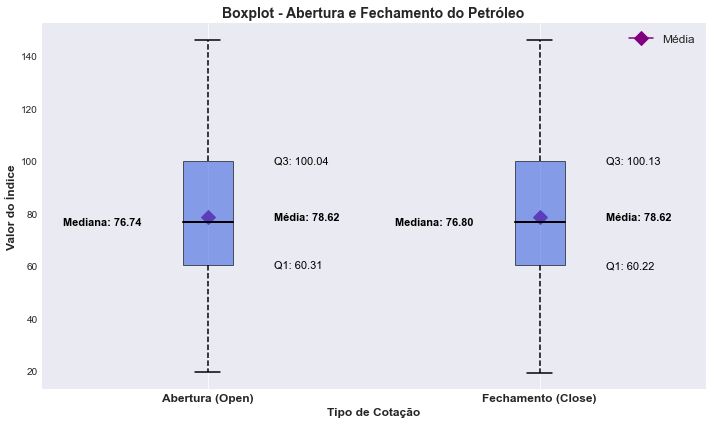

In [80]:
# Selecionando os dados
datav = [data['Open'], data['Close']]

# Configuração do estilo
plt.style.use('seaborn-darkgrid')  # Estilo moderno e clean

# Criando o gráfico
plt.figure(figsize=(10, 6))

box = plt.boxplot(datav, patch_artist=True, 
                  boxprops=dict(facecolor='royalblue', alpha=0.6, color='black'),  # Caixa azul transparente
                  medianprops=dict(color='black', linewidth=2),  # Mediana preta e mais espessa
                  whiskerprops=dict(color='black', linestyle='--', linewidth=1.5),  # Bigodes tracejados
                  capprops=dict(color='black', linewidth=1.5),  # Tampas dos bigodes
                  flierprops=dict(markerfacecolor='red', marker='o', markersize=8, alpha=0.8))  # Outliers destacados

# Configuração dos eixos
plt.xticks([1, 2], ['Abertura (Open)', 'Fechamento (Close)'], fontsize=12, fontweight='bold')
plt.ylabel('Valor do Índice', fontsize=12, fontweight='bold')
plt.xlabel('Tipo de Cotação', fontsize=12, fontweight='bold')

# Adicionando linhas para a média e melhorando a visualização dos textos
for i, data_set in enumerate(datav, start=1):
    mean = np.mean(data_set)
    Q1 = np.percentile(data_set, 25)
    median = np.median(data_set)
    Q3 = np.percentile(data_set, 75)

    # Adicionando ponto da média
    plt.plot(i, mean, marker='D', color='purple', markersize=10, label='Média' if i == 1 else "")

    # Ajuste nos deslocamentos para evitar sobreposição
    deslocamento_direita = 0.2  
    deslocamento_esquerda = -0.2  

    # Adicionando os valores no gráfico
    plt.text(i + deslocamento_direita, Q1, f'Q1: {Q1:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=11, color='black')
    plt.text(i + deslocamento_esquerda, median, f'Mediana: {median:.2f}', horizontalalignment='right', verticalalignment='center', fontsize=11, color='black', fontweight='bold')
    plt.text(i + deslocamento_direita, Q3, f'Q3: {Q3:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=11, color='black')
    plt.text(i + deslocamento_direita, mean, f'Média: {mean:.2f}', horizontalalignment='left', verticalalignment='center', fontsize=11, color='black', fontweight='bold')

# Título principal
plt.title("Boxplot - Abertura e Fechamento do Petróleo", fontsize=14, fontweight='bold')

# Melhorando a legenda
plt.legend(loc="upper right", fontsize=12)

# Exibir o gráfico com um grid suave
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [81]:
# Definindo função para calcular percentual de outliers
def calcular_outliers_percentual(dados):
    # Não remove NaN, usa todos os dados
    # Calculo dos quartis
    Q1 = np.percentile(dados, 25)
    Q3 = np.percentile(dados, 75)
    IQR = Q3 - Q1

    # Calculando os limites para outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Exibir os valores de Q1, Q3, IQR e os limites
    print(f'Q1: {Q1}, Q3: {Q3}, IQR: {IQR}')
    print(f'Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}')

    # Contando outliers
    outliers = dados[(dados < limite_inferior) | (dados > limite_superior)]

    # Calculando percentual de outliers
    percentual_outliers = (len(outliers) / len(dados)) * 100

    return percentual_outliers


Na análise dos dados de Abertura (Open) e Fechamento (Close), foi utilizado o método do Intervalo Interquartil (IQR) para identificar a presença de outliers. Abaixo, os resultados obtidos para ambos os conjuntos de dados:

Abertura (Open):

Q1 (primeiro quartil): 60.31

Q3 (terceiro quartil): 100.04

IQR (Intervalo Interquartil): 39.74

Limite Inferior: 0.70

Limite Superior: 159.65

Percentual de Outliers: 0.00%

Com base nos cálculos, os dados de Abertura não apresentam nenhum valor fora dos limites estabelecidos, indicando que não há outliers detectados nesse conjunto de dados. A faixa de variação entre os limites inferior e superior está bem definida, e o percentual de outliers é zero.

Fechamento (Close):

Q1 (primeiro quartil): 60.22

Q3 (terceiro quartil): 100.13

IQR (Intervalo Interquartil): 39.91

Limite Inferior: 0.35

Limite Superior: 160.01

Percentual de Outliers: 0.00%

De forma similar, os dados de Fechamento também não apresentam outliers. A faixa de valores aceitáveis entre o limite inferior e superior também não foi ultrapassada, resultando em um percentual de outliers de 0.00%.

In [82]:
# Calculando o percentual dos valores de abertura
percentual_outliers_open = calcular_outliers_percentual(data['Open'])
print(f'Percentual de outliers em Open: {percentual_outliers_open:.2f}%','\n')

# Calculando o percentual dos valores de fechamento
percentual_outliers_close = calcular_outliers_percentual(data['Close'])
print(f'Percentual de outliers em Close: {percentual_outliers_close:.2f}%')

Q1: 60.30500030517578, Q3: 100.04499816894531, IQR: 39.73999786376953
Limite Inferior: 0.6950035095214844, Limite Superior: 159.6549949645996
Percentual de outliers em Open: 0.00% 

Q1: 60.220001220703125, Q3: 100.1349983215332, IQR: 39.91499710083008
Limite Inferior: 0.3475055694580078, Limite Superior: 160.00749397277832
Percentual de outliers em Close: 0.00%


# 4.2 Análise de Tendências

Entre 2007 e 2025, os preços do petróleo Brent passaram por grandes variações devido a fatores econômicos, políticos e geopolíticos:

Alta e Queda em 2008: O Brent atingiu níveis recordes devido à forte demanda global e tensões no Oriente Médio. No entanto, a crise financeira de 2008 derrubou os preços de US$ 140 para cerca de US$ 40 por barril.

Recuperação e Volatilidade (2009-2014): Os preços se recuperaram impulsionados por pacotes de estímulo, mas oscilaram devido a tensões no Oriente Médio e ao aumento da produção de petróleo de xisto nos EUA.

Queda de 2014-2016: O aumento da produção de xisto e a decisão da OPEP de manter a produção elevada derrubaram os preços de mais de US$ 100 para cerca de US$ 30 por barril.

Impacto da Pandemia (2020): A COVID-19 reduziu drasticamente a demanda, levando o Brent a níveis negativos no mercado de futuros. A recuperação começou com a reabertura econômica e a vacinação.

Recuperação Pós-Pandemia (2021-2025): O aumento da demanda global, tensões geopolíticas (como a guerra na Ucrânia) e ajustes da OPEP+ impulsionaram os preços novamente.

A trajetória do Brent demonstra sua sensibilidade a crises financeiras, decisões de produção e eventos globais, tornando-o um indicador essencial da economia mundial.

In [83]:
print(data.columns)


Index(['Date', 'Open', 'Close'], dtype='object')


In [84]:
# Criando o gráfico para o preço de fechamento
fig_close = go.Figure()

# Adicionando traço para o preço de fechamento
fig_close.add_trace(go.Scatter(x=data["Date"], y=data["Close"], mode='lines+markers', name='Preço de Fechamento',
                               line=dict(color='#1f77b4', width=2), marker=dict(size=4, color='#1f77b4')))

# Adicionando linha de mínimo
min_price_close = data["Close"].min()
max_price_close = data["Close"].max()
fig_close.add_trace(go.Scatter(x=data["Date"], y=[min_price_close] * len(data), mode='lines', name='Mínimo Fechamento',
                               line=dict(color='#a6a6a6', dash='dash', width=1)))

# Adicionar linha de máximo
fig_close.add_trace(go.Scatter(x=data["Date"], y=[max_price_close] * len(data), mode='lines', name='Máximo Fechamento',
                               line=dict(color='#d62728', dash='dash', width=1)))

# Adicionando linhas de média e mediana
mean_close = data["Close"].mean()
median_close = data["Close"].median()
fig_close.add_trace(go.Scatter(x=data["Date"], y=[mean_close] * len(data), mode='lines', name='Média Fechamento',
                               line=dict(color='#2ca02c', dash='dot', width=2)))
fig_close.add_trace(go.Scatter(x=data["Date"], y=[median_close] * len(data), mode='lines', name='Mediana Fechamento',
                               line=dict(color='#ff7f0e', dash='dot', width=2)))

# Ajustando a legenda e layout
fig_close.update_layout(title="Preço de Fechamento entre 2007-2025",
                        xaxis_title="Ano",
                        yaxis_title="Valor Cotação",
                        legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center', yanchor='bottom'),
                        template='plotly_white')

# Mostrando gráfico de fechamento
fig_close.show()

# Criando o gráfico para o preço de abertura
fig_open = go.Figure()

# Adicionando traço para o preço de abertura
fig_open.add_trace(go.Scatter(x=data["Date"], y=data["Open"], mode='lines+markers', name='Preço de Abertura',
                              line=dict(color='#ff9999', width=2), marker=dict(size=4, color='#ff9999')))

# Adicionando linha de mínimo
min_price_open = data["Open"].min()
max_price_open = data["Open"].max()
fig_open.add_trace(go.Scatter(x=data["Date"], y=[min_price_open] * len(data), mode='lines', name='Mínimo Abertura',
                              line=dict(color='#a6a6a6', dash='dash', width=1)))

# Adicionar linha de máximo
fig_open.add_trace(go.Scatter(x=data["Date"], y=[max_price_open] * len(data), mode='lines', name='Máximo Abertura',
                              line=dict(color='#d62728', dash='dash', width=1)))

# Adicionando linhas de média e mediana
mean_open = data["Open"].mean()
median_open = data["Open"].median()
fig_open.add_trace(go.Scatter(x=data["Date"], y=[mean_open] * len(data), mode='lines', name='Média Abertura',
                              line=dict(color='#2ca02c', dash='dot', width=2)))
fig_open.add_trace(go.Scatter(x=data["Date"], y=[median_open] * len(data), mode='lines', name='Mediana Abertura',
                              line=dict(color='#ff7f0e', dash='dot', width=2)))

# Ajustando a legenda e layout
fig_open.update_layout(title="Preço de Abertura entre 2007-2025",
                       xaxis_title="Ano",
                       yaxis_title="Valor Cotação",
                       legend=dict(x=0.5, y=1.1, orientation='h', xanchor='center', yanchor='bottom'),
                       template='plotly_white')

# Mostrando gráfico de abertura
fig_open.show()


In [85]:
print(data.columns)
# Verificar tipos de dados
print(data.dtypes)

Index(['Date', 'Open', 'Close'], dtype='object')
Date     datetime64[ns]
Open            float64
Close           float64
dtype: object


# 5. Série Temporal

Abaixo será realizado a decomposição da série temporal, que basicamente é uma técnica que permite analisar as diferentes componentes de uma série ao longo do tempo, facilitando a interpretação e modelagem dos dados. As principais componentes incluem:

- Tendência (Trend): A direção de longo prazo da série, que pode ser crescente, decrescente ou estável.

- Sazonalidade (Seasonality): Padrões que se repetem em intervalos regulares, como variações mensais ou anuais, influenciados por fatores como clima ou feriados.

- Ciclos (Cycles): Flutuações na série que ocorrem em períodos irregulares, muitas vezes relacionadas a fatores econômicos.

- Resíduos (Residuals): Variações aleatórias que não podem ser atribuídas às outras componentes, representando o "ruído" da série.

# 5.1 Decomposição Multiplicativa

Neste tipo de decomposição, a série é expressa como o produto de suas componentes (tendência, sazonalidade e resíduos). Isso é apropriado quando a amplitude das variações sazonais aumenta com o tempo. Aqui definiremos o período da sazonalidade como anual para o valor de fechamento, visto que é uma base diária.



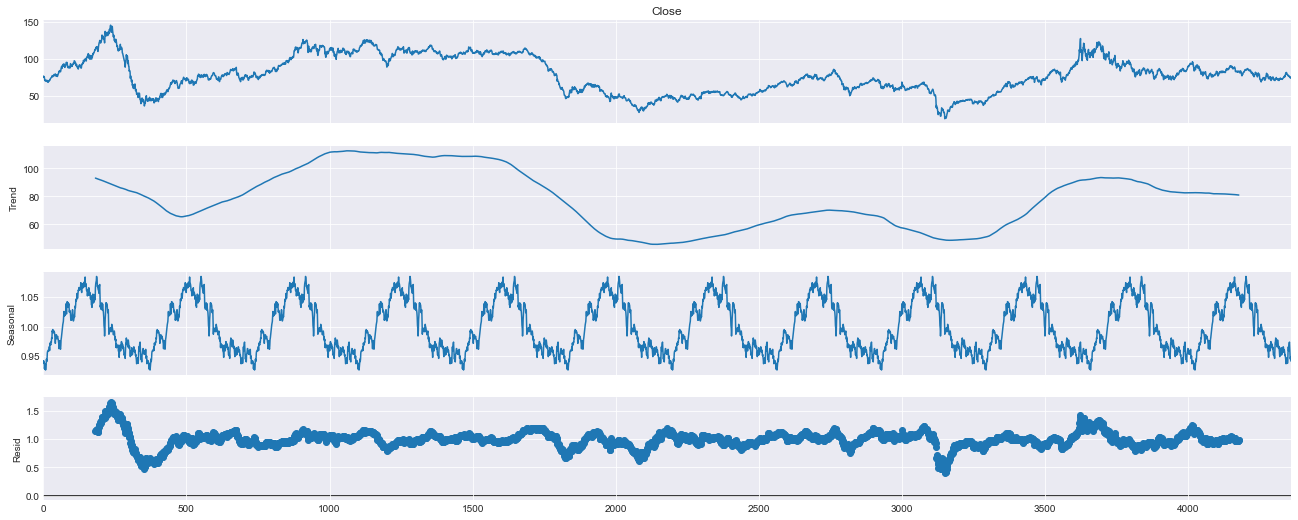

In [86]:
#Realizando decomposição
result = seasonal_decompose(data["Close"], model="multiplicative", period=365)
fig = result.plot()
fig.set_size_inches(20, 8)

Ao selecionar os primeiros 380 pontos da série temporal, conforme o gráfico abaixo, é possível identificar com maior clareza os padrões sazonais ao longo do tempo. Essa visualização revela flutuações regulares na cotação do petróleo, permitindo observar como os preços tendem a subir ou cair em determinados períodos.

Inicialmente, observa-se uma leve alta, seguida por uma queda suave e uma recuperação entre o começo e aproximadamente o ponto 180. Após esse intervalo, os valores entram em um declínio gradual até cerca de 375 pontos, momento em que se inicia uma nova tendência de alta.

<AxesSubplot:>

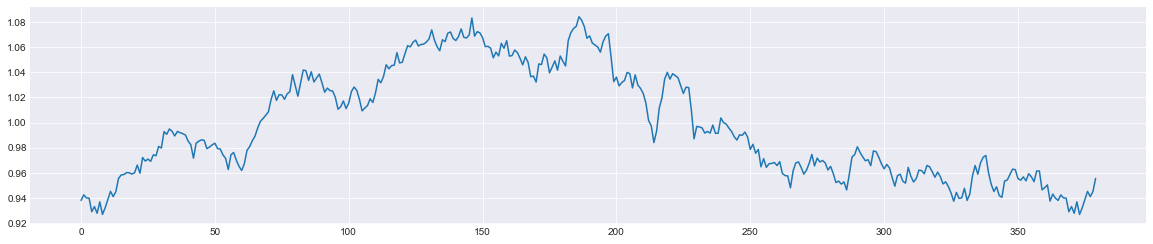

In [87]:
result.seasonal.iloc[:380].plot(figsize=(20, 4))

# 5.2 Decomposição Aditiva

A decomposição aditiva é uma técnica utilizada em análise de séries temporais para separar uma série em suas componentes principais: tendência, sazonalidade e resíduos. Este método é apropriado quando as variações sazonais e os resíduos não aumentam com o tempo, ou seja, a amplitude das flutuações não é proporcional ao nível da série.

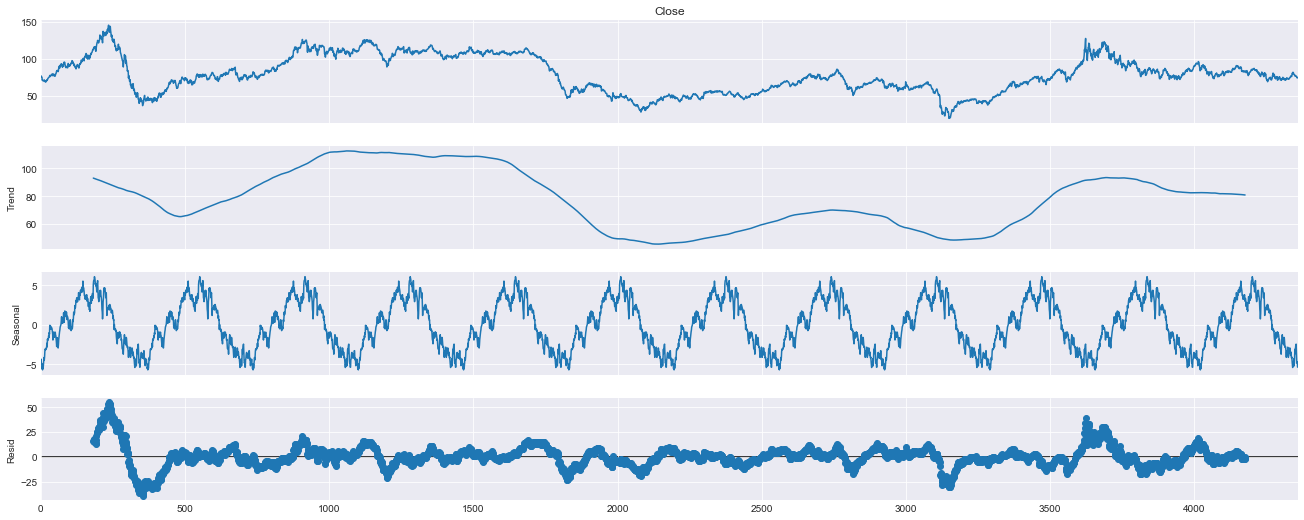

In [88]:
# Realizando Decomposição Aditiva
result = seasonal_decompose(data["Close"], model="additive", period=365)
fig = result.plot()
fig.set_size_inches(20, 8)

# 5.3 Decomposição Autoregressiva
A decomposição autoregressiva é uma técnica que separa uma série temporal em componentes distintas, como tendência, sazonalidade e resíduos, utilizando modelos que consideram a dependência temporal dos dados. Isso permite entender como os valores passados da série influenciam os valores atuais e futuros, facilitando a previsão e análise de padrões.

# 5.3.1 Auto correlação (ACF)

Com o objetivo de encontrar os coeficientes de intercepção da ACF (Autocorrelation Function) e comparar a funcionalidade dos modelos de previsão, será utilizado os dados dos últimos 10 anos. 

In [89]:
data.reset_index(inplace=True)  # Volta o índice para uma coluna normal


In [90]:
print(data.columns)
# Verificar tipos de dados
print(data.dtypes)

Index(['index', 'Date', 'Open', 'Close'], dtype='object')
index             int64
Date     datetime64[ns]
Open            float64
Close           float64
dtype: object


In [91]:
# Definindo a coluna 'Date' como índice corretamente
data.set_index('Date', inplace=True)

# Garantindo que o índice está no formato correto
data.index = pd.to_datetime(data.index)

# Filtrando os últimos 10 anos
data10 = data.loc['2015-01-01':'2025-02-01']


In [92]:
#Definindo função acf
def plot_acf(data10, lags=365, title="Autocorrelação da Série Temporal"):

    fig, ax = plt.subplots(figsize=(16, 5))

    _plot_acf(data10, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.acf(data10, alpha=0.05, nlags=365)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da ACF interceptam o limite em lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da ACF não interceptam o limite")

O resultado do ACF indica que a autocorrelação da série temporal atinge o limite de significância (definido pelo intervalo de confiança) no lag 171. Isso sugere que, após o 171º ponto (ou atraso) na série temporal, a autocorrelação entre os valores da série se torna estatisticamente insignificante, ou seja, a dependência temporal diminui significativamente após esse ponto.

Isso significa que, para lags abaixo de 171, há uma correlação significativa entre os valores da série em intervalos de tempo consecutivos, o que pode indicar que há uma estrutura sazonal ou cíclica importante nessa parte da série.

Após o lag 171, a série tende a se tornar mais "aleatória", com menos relação entre os valores da série em lags mais distantes, mostrando uma decadência da autocorrelação.

Esse resultado pode ser relevante para a construção de modelos preditivos, como ARIMA ou SARIMA, onde os parâmetros do modelo podem ser configurados com base no comportamento observado até o lag 171. Após esse ponto, os padrões sazonais ou dependências de curto prazo podem não ser mais significativos.

Os coeficientes da ACF interceptam o limite em lag 171


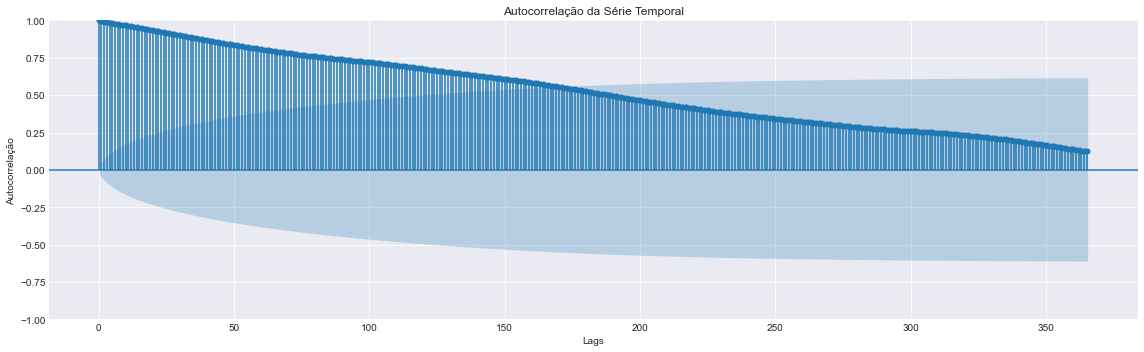

In [93]:
plot_acf(data10["Close"])

# 5.3.2 Auto correlação parcial (PACF)

Autocorrelação Parcial (PACF) é uma técnica estatística que mede a correlação entre uma série temporal e suas próprias defasagens (lags), controlando para as defasagens intermediárias. Em outras palavras, enquanto a autocorrelação simples mede a relação linear entre a série e suas defasagens, a PACF identifica a correlação direta de um lag específico, removendo a influência de outros lags.

O resultado do PACF abaixo indica que a autocorrelação parcial da série temporal atinge o limite de significância (definido pelo intervalo de confiança) no lag 2. Isso sugere que, após o segundo ponto de defasagem (lag 2), a autocorrelação parcial entre os valores da série se torna estatisticamente insignificante, ou seja, a dependência temporal diminui significativamente após esse ponto.

**Explicação do Comportamento:**

Padrões sazonais ou cíclicos: Para lags até 2, há uma correlação significativa entre os valores da série em intervalos de tempo consecutivos, o que pode indicar que as primeiras defasagens (lags 1 e 2) possuem uma estrutura importante para a previsão de valores futuros. Essas defasagens refletem a influência de valores anteriores na determinação dos preços futuros.

Decadência da autocorrelação: Após o lag 2, a série tende a se tornar mais "aleatória", com pouca ou nenhuma relação entre os valores da série em lags mais distantes. Isso implica que, após o segundo lag, a previsão dos valores futuros não se beneficia mais das informações trazidas pelas defasagens subsequentes.

Esse resultado é relevante para modelos preditivos, como ARIMA ou SARIMA, onde os parâmetros do modelo podem ser ajustados com base na observação da série até o lag 2. A partir desse ponto, os padrões sazonais ou dependências de curto prazo podem não ser mais significativos, e as defasagens adicionais podem ser descartadas para melhorar a performance do modelo.

In [94]:
# Definindo o pacf

def plot_pacf(data1, lags=171, title="Autocorrelação Parcial da Série Temporal"):

    fig, ax = plt.subplots(figsize=(15, 5))

    _plot_pacf(data1, lags=lags, ax=ax, alpha=0.05)
    ax.set_title(title)
    ax.set_xlabel("Lags")
    ax.set_ylabel("Autocorrelação Parcial")
    fig.set_tight_layout(True)

    acf_x = sm.tsa.pacf(data1, alpha=0.05, nlags=lags)
    acf, ci = acf_x[:2]
    intercept_point = np.where(abs(acf) < (ci[:, 1] - acf))
    if intercept_point[0].size > 0:
        print(
            f"Os coeficientes da PACF interceptam o limite em lag {intercept_point[0][0]}"
        )
    else:
        print("Os coeficientes da PACF não interceptam o limite")

Os coeficientes da PACF interceptam o limite em lag 2


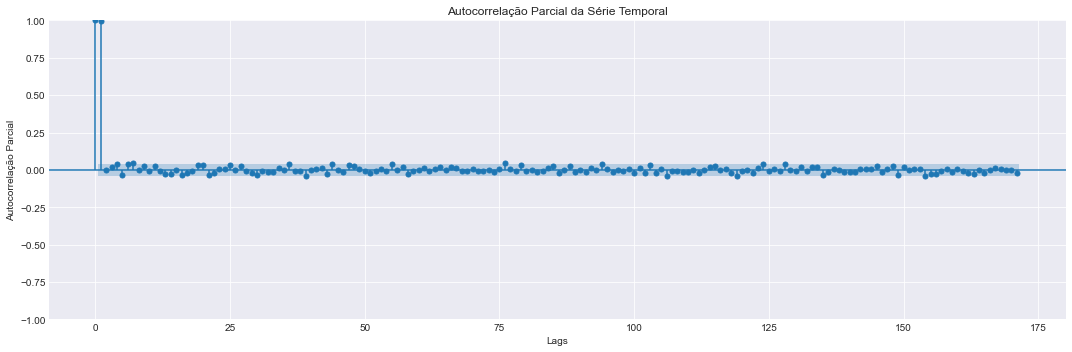

In [95]:
plot_pacf(data10["Close"])

# 5.3.3 Diferenciação para estacionariedade (ADF)

A diferenciação é uma técnica utilizada para transformar uma série temporal não estacionária em estacionária, o que significa que suas propriedades, como média e variância, permanecem constantes ao longo do tempo. Muitos modelos de previsão, como os modelos autoregressivos (AR), exigem que a série seja estacionária para funcionar corretamente. Primeiramente, será verificado se a série original é estacionária. Caso não seja, será necessário aplicar o método de diferenciação para remover tendências. Em seguida, será realizada uma nova verificação para garantir que a série tenha se tornado estacionária após o processamento.

In [96]:
# Realizando o teste ADF na série temporal
adf_result = sm.tsa.adfuller(data10["Close"])

# Exibindo todos os índices do resultado
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Number of Lags Used: {adf_result[2]}")
print(f"Number of Observations Used: {adf_result[3]}")
print(f"Critical Values: {adf_result[4]}")

# Verificando se a série é estacionária
if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")


ADF Statistic: -1.9886063677485237
p-value: 0.29159104622613785
Number of Lags Used: 6
Number of Observations Used: 2529
Critical Values: {'1%': -3.432938355012086, '5%': -2.8626835272597217, '10%': -2.567378742868999}
A série temporal não é estacionária


A análise do resultado do teste ADF (Augmented Dickey-Fuller) indica que a série temporal não é estacionária com base nos valores fornecidos. 

**Resultados do Teste ADF:**
ADF Statistic: -1.9886

O valor da estatística ADF é -1.9886. Esse valor será comparado com os valores críticos (em diferentes níveis de significância) para determinar se podemos rejeitar a hipótese nula de que a série tem uma raiz unitária (ou seja, é não estacionária).
p-value: 0.2916

O p-valor é 0.2916. Para rejeitar a hipótese nula de não estacionariedade, o p-valor deve ser menor que 0.05. Como o p-valor é maior que 0.05, não podemos rejeitar a hipótese nula e, portanto, concluímos que a série não é estacionária.
Number of Lags Used: 6

O número de lags (atrasos) utilizados no teste foi 6. O número de lags pode influenciar os resultados, dependendo da natureza dos dados.
Number of Observations Used: 2529

O número de observações utilizadas para o teste foi 2529, que é o número total de pontos da série temporal considerados.

**Critical Values:**

1%: -3.4329

5%: -2.8627

10%: -2.5674

Esses são os valores críticos para diferentes níveis de significância (1%, 5%, e 10%). Se a estatística ADF for menor que o valor crítico, podemos rejeitar a hipótese nula e concluir que a série é estacionária. Neste caso, a estatística ADF de -1.9886 é maior que todos esses valores críticos, indicando que não rejeitamos a hipótese nula de não estacionariedade.

O p-valor maior que 0.05 indica que não há evidência suficiente para rejeitar a hipótese nula, ou seja, a série temporal não é estacionária.
Então para tornar a série estacionária, será aplicado abaixo a primeira diferenciação para remover a tendência ou as flutuações sazonais.

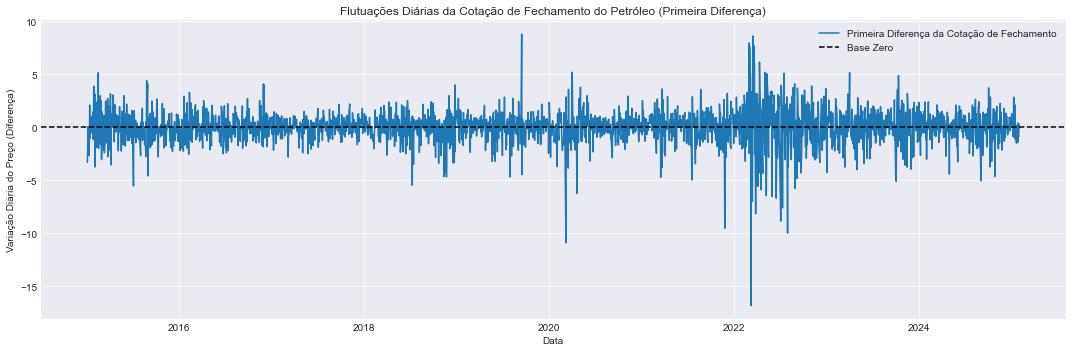

In [97]:
# Aplicando a diferenciação
data10["Close_diff"] = data10["Close"].diff()

# Plotando o gráfico da série diferenciada
plt.figure(figsize=(15, 5))
plt.plot(data10["Close_diff"], label="Primeira Diferença da Cotação de Fechamento", color='tab:blue')
plt.axhline(y=0, color='black', linestyle='--', label='Base Zero')  # Linha de base para facilitar visualização
plt.title("Flutuações Diárias da Cotação de Fechamento do Petróleo (Primeira Diferença)")
plt.xlabel("Data")
plt.ylabel("Variação Diária do Preço (Diferença)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 5.3.3.1 Verificação de Estacionaridade na Série após 1º Diferenciação

Os resultados do teste ADF indicam que a série temporal se tornou estacionária após a primeira diferenciação. A seguir, a interpretação detalhada de cada valor obtido:

ADF Statistic: -22.706810914150694: A estatística do teste ADF é muito negativa. Quanto mais negativo for esse valor, mais forte a evidência de que a série é estacionária. No nosso caso, o valor de -22.70 é bem inferior aos valores críticos, sugerindo que a série é extremamente próxima de ser estacionária.

p-value: 0.0: O p-valor é extremamente baixo (próximo de zero), o que indica que a hipótese nula (de que a série não é estacionária) pode ser rejeitada com alta confiança. Esse valor reforça a conclusão de que a série é estacionária.

Critical Values:

1%: -3.432938355012086

5%: -2.8626835272597217

10%: -2.567378742868999

Esses valores críticos representam os limites para diferentes níveis de significância. A estatística ADF de -22.70 é significativamente menor do que o valor crítico de 1% (-3.43), o que confirma que a série é estacionária. Esse resultado indica que a série não apresenta mais tendências ou variações de longo prazo, o que é uma característica essencial para modelagem de séries temporais.

In [98]:
# Diferenciando 1 vez

adf_result = sm.tsa.adfuller(data10["Close"].diff().dropna())
print(f"ADF Statistic: {adf_result[0]}")
print(f"p-value: {adf_result[1]}")
print(f"Number of Lags Used: {adf_result[2]}")
print(f"Number of Observations Used: {adf_result[3]}")
print(f"Critical Values: {adf_result[4]}")


if adf_result[1] < 0.05:
    print("A série temporal é estacionária")
else:
    print("A série temporal não é estacionária")

ADF Statistic: -22.706810914150694
p-value: 0.0
Number of Lags Used: 5
Number of Observations Used: 2529
Critical Values: {'1%': -3.432938355012086, '5%': -2.8626835272597217, '10%': -2.567378742868999}
A série temporal é estacionária


# 5.3.4 Coeficientes de autoregressão

Abaixo será calculado os coeficientes de autocorrelação (ACF) e autocorrelação parcial (PACF) para determinar os parâmetros de um modelo ARIMA, especificamente p (para autoregressão) e q (para média móvel). A diferenciação (d) aplicada acima é usada para garantir que a série seja estacionária, o que é essencial para a aplicação de modelos ARIMA.

In [99]:
# Calculando a ACF (Autocorrelação) para a série temporal "Close"
# ACF estima a autocorrelação entre os valores da série em diferentes lags (atrasos).
acf_x = sm.tsa.acf(data10["Close"], alpha=0.05, nlags=365)
acf, ci = acf_x[:2]  # O primeiro valor é a autocorrelação, o segundo é o intervalo de confiança

# Identificando o valor de q (termo de média móvel) a partir da ACF
# O valor de q é o número de lags até a autocorrelação se tornar não significativa
# Aqui, estamos verificando o primeiro ponto onde a autocorrelação se torna menor que o limite superior do intervalo de confiança (ci[:, 1])
q = np.where(abs(acf) < (ci[:, 1] - acf))[0][0]

# Calculando a PACF (Autocorrelação Parcial) para a série temporal "Close"
# A PACF mede a correlação entre uma variável e seus próprios lags, mas elimina as influências de lags anteriores.
pacf_x = sm.tsa.pacf(data10["Close"], alpha=0.05, nlags=30)
pacf, ci = pacf_x[:2]  # O primeiro valor é a PACF, o segundo é o intervalo de confiança

# Identificando o valor de p (termo autoregressivo) a partir da PACF
# O valor de p é o número de lags até a autocorrelação parcial se tornar não significativa
# Aqui, estamos verificando o primeiro ponto onde a PACF se torna menor que o limite superior do intervalo de confiança (ci[:, 1])
p = np.where(abs(pacf) < (ci[:, 1] - pacf))[0][0]

# O valor de d (número de diferenciações) é definido com base na análise de estacionariedade da série temporal
# A diferenciação é realizada para remover tendências e tornar a série estacionária
# Aqui, já sabemos que foi necessária apenas 1 diferenciação para tornar a série estacionária
d = 1

# Exibindo os valores de p, d e q
print(f"Valor de p (AR): {p}")
print(f"Valor de d (diferenciação): {d}")
print(f"Valor de q (MA): {q}")


Valor de p (AR): 2
Valor de d (diferenciação): 1
Valor de q (MA): 171


# 5.3.5 Determinando os parâmetros de sazonalidade

Abaixo será realizada a modelagem da série temporal de preços de fechamento, identificando automaticamente os melhores parâmetros para um modelo ARIMA sazonal e fornece um resumo dos resultados do ajuste do modelo. Foi definido a periodicidade sazonal de forma mensal, ou seja, o modelo considerará uma sazonalidade de 12 meses.

In [100]:
model = pm.auto_arima(
    data10["Close"],
    seasonal=True,
    m=12,
    stepwise=True,
)

# Resumo dos parâmetros detectados pelo modelo
print(model.summary())

# Ordem sazonal detectada
seasonal_order = model.seasonal_order
print(f"Ordem Sazonal Detectada: {seasonal_order}")


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2536
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -4787.027
Date:                Tue, 18 Feb 2025   AIC                           9576.054
Time:                        16:36:20   BIC                           9581.892
Sample:                             0   HQIC                          9578.172
                               - 2536                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         2.5571      0.030     85.792      0.000       2.499       2.615
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):             10161.82
Prob(Q):                              0.72   Pr

# 6. Organizando Dados em Treino e Teste para Análise

In [101]:
# Calculando o tamanho da divisão
train_size = int(len(data10) * 0.8)  # Usando 80% dos dados para treino, 20% para teste
train = data10[:train_size]  # Conjunto de treinamento
test = data10[train_size:]  # Conjunto de teste

# Verificando o tamanho dos conjuntos
print(f"Tamanho do conjunto de treino: {len(train)}")
print(f"Tamanho do conjunto de teste: {len(test)}")

# Opcional: Exibindo os primeiros e últimos elementos dos conjuntos para validar
print("\nConjunto de Treinamento (primeiros 5):")
print(train.head())

print("\nConjunto de Teste (últimos 5):")
print(test.tail())


Tamanho do conjunto de treino: 2028
Tamanho do conjunto de teste: 508

Conjunto de Treinamento (primeiros 5):
            index       Open      Close  Close_diff
Date                                               
2015-01-02   1818  57.630001  56.419998         NaN
2015-01-05   1819  56.290001  53.110001   -3.309998
2015-01-06   1820  53.230000  51.099998   -2.010002
2015-01-07   1821  51.060001  51.150002    0.050003
2015-01-08   1822  51.000000  50.959999   -0.190002

Conjunto de Teste (últimos 5):
            index       Open      Close  Close_diff
Date                                               
2025-01-27   4349  78.550003  77.080002   -1.419998
2025-01-28   4350  77.070000  77.489998    0.409996
2025-01-29   4351  77.629997  76.580002   -0.909996
2025-01-30   4352  76.860001  76.870003    0.290001
2025-01-31   4353  77.000000  76.760002   -0.110001


In [102]:
print(data10.columns)


Index(['index', 'Open', 'Close', 'Close_diff'], dtype='object')


In [107]:
data10.reset_index('Date', inplace=True)

In [104]:
data10.set_index('Date', inplace=True)

In [105]:
p, d, q

(2, 1, 171)

#  7. Modelo LSTM

O LSTM (Long Short-Term Memory) é uma rede neural recorrente (RNN) projetada para capturar dependências de longo prazo em séries temporais, mantendo informações por períodos prolongados. Ele se destaca em identificar tendências e padrões sazonais complexos, além de ser menos sensível a ruídos pontuais em comparação com modelos como ARIMA ou SARIMA.

In [110]:
# Supondo que data1 é o seu DataFrame
data1 = data10[['Date', 'Open', 'Close']].copy()
data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index('Date', inplace=True)

# Normalização dos dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data1[['Close']])

# Dividindo os dados em conjuntos de treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Função para criar as janelas de dados
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Criando as janelas de dados
time_step = 60  # Número de períodos para olhar para trás
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reformatação dos dados para o formato [amostras, tempo, características]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Definindo o modelo LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Previsão de um único valor

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo
model.fit(X_train, y_train, epochs=50, batch_size=32)

# Fazendo previsões
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invertendo a normalização para calcular as métricas
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

# Invertendo a normalização dos dados de teste
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/50
62/62 [==============================] - 6s 42ms/step - loss: 0.0163
Epoch 2/50
62/62 [==============================] - 2s 40ms/step - loss: 0.0030
Epoch 3/50
62/62 [==============================] - 4s 57ms/step - loss: 0.0026
Epoch 4/50
62/62 [==============================] - 2s 36ms/step - loss: 0.0025
Epoch 5/50
62/62 [==============================] - 3s 44ms/step - loss: 0.0022
Epoch 6/50
62/62 [==============================] - 3s 41ms/step - loss: 0.0025
Epoch 7/50
62/62 [==============================] - 2s 37ms/step - loss: 0.0024
Epoch 8/50
62/62 [==============================] - 2s 37ms/step - loss: 0.0022
Epoch 9/50
62/62 [==============================] - 2s 37ms/step - loss: 0.0020
Epoch 10/50
62/62 [==============================] - 2s 39ms/step - loss: 0.0018
Epoch 11/50
62/62 [==============================] - 3s 43ms/step - loss: 0.0020
Epoch 12/50
62/62 [==============================] - 2s 36ms/step - loss: 0.0020
Epoch 13/50
62/62 [==================

In [112]:
# Calculando as métricas para o LSTM
metrics_lstm = calculate_metrics(y_test_actual, test_predict)

# Imprimindo as métricas
print("LSTM Metrics:")
print_metrics(metrics_lstm)

LSTM Metrics:
MAE: 1.7400199497572795
MSE: 4.407297518586254
MAPE: 2.16 %
Acurácia: 0.87 %


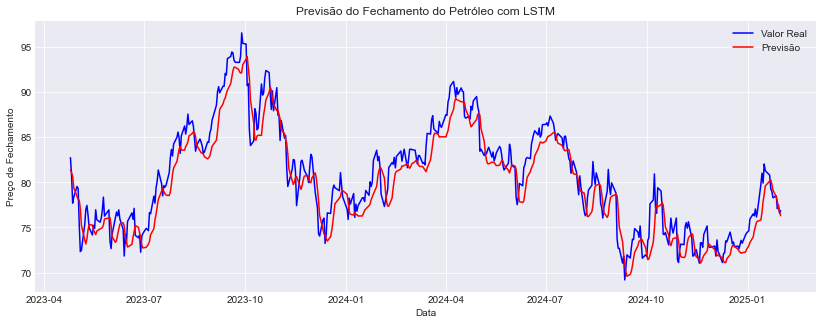

In [113]:
# Convertendo o índice para um array numpy
train_size_np = np.array(data1.index[train_size + time_step + 1:])
y_test_actual_np = np.array(y_test_actual)
test_predict_np = np.array(test_predict)

# Visualizando os resultados
plt.figure(figsize=(14, 5))
plt.plot(train_size_np, y_test_actual_np, color='blue', label='Valor Real')
plt.plot(train_size_np, test_predict_np, color='red', label='Previsão')
plt.title('Previsão do Fechamento do Petróleo com LSTM')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.show()


# 8. ARIMA

In [114]:
#import pandas as pd
#import numpy as np
#from sklearn.preprocessing import MinMaxScaler
#from statsmodels.tsa.arima.model import ARIMA
#import matplotlib.pyplot as plt

# Supondo que data1 é o seu DataFrame
data1 = data10[['Date', 'Open', 'Close']].copy()
data1['Date'] = pd.to_datetime(data1['Date'])
data1.set_index('Date', inplace=True)

# Normalização dos dados (converte para numpy array)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data1[['Close']].values)  # Converte 'Close' para numpy array

# Dividindo os dados em conjuntos de treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# ARIMA exige um formato de dados 1D, então vamos usar apenas a coluna 'Close'
train_data = train_data.flatten()
test_data = test_data.flatten()

# Ajustando o modelo ARIMA (parâmetros p, d, q podem ser ajustados conforme necessário)
# A escolha de p, d, q depende da análise de autocorrelação e da estacionaridade da série temporal
model = ARIMA(train_data, order=(p, 1, 10))  # Exemplo de parâmetros (p=5, d=1, q=0)
model_fit = model.fit()

# Fazendo previsões
train_predict = model_fit.predict(start=0, end=len(train_data)-1, typ='levels')
test_predict = model_fit.forecast(steps=len(test_data))

# Invertendo a normalização para calcular as métricas
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))



In [115]:
# Invertendo a normalização para obter os valores reais de 'Close' na escala original
y_test_actual = scaler.inverse_transform(test_data.reshape(-1, 1))  # Dados reais de teste

# Agora, calculamos as métricas comparando os valores reais e as previsões
metrics_arima = calculate_metrics(y_test_actual.flatten(), test_predict.flatten())

# Imprimindo as métricas
print("ARIMA Metrics:")
print_metrics(metrics_arima)


ARIMA Metrics:
MAE: 6.23122658576791
MSE: 56.75084282144139
MAPE: 8.05 %
Acurácia: -0.83 %


# 9. Comparando Modelos

In [116]:
# Supondo que as métricas dos outros modelos já foram calculadas
df = pd.DataFrame(
    [metrics_arima, metrics_lstm],
    columns=["MAE", "MSE", "MAPE", "R²"],
    index=[ "ARIMA", "LSTM"],
)

df.sort_values(by="MAPE", ascending=True)

# Exibindo o DataFrame ordenado
#print(df_sorted)


MAE        MSE      MAPE        R²
LSTM   1.740020   4.407298  2.155215  0.865924
ARIMA  6.231227  56.750843  8.047511 -0.834802

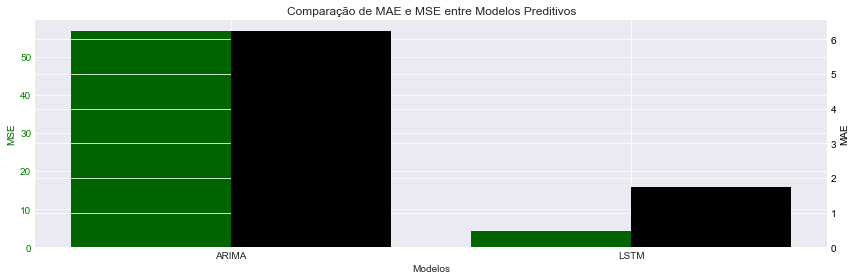

In [123]:
# Largura das barras
bar_width = 0.4

# Posições das barras no eixo X
models = df.index
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

# Gráfico 1: Comparação de MAE e MSE com escalas separadas
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotar MSE no eixo da esquerda
ax1.set_xlabel('Modelos')
ax1.set_ylabel('MSE', color='darkgreen')
ax1.bar(r1, df['MSE'], color='darkgreen', width=bar_width, label='MSE')
ax1.tick_params(axis='y', labelcolor='g')

# Criar um segundo eixo Y para o MAE
ax2 = ax1.twinx()
ax2.set_ylabel('MAE', color='black')
ax2.bar(r2, df['MAE'], color='black', width=bar_width, label='MAE')
ax2.tick_params(axis='y', labelcolor='black')

# Ajustar os ticks do eixo X
plt.xticks([r + bar_width/2 for r in range(len(models))], models)

# Título e legendas
plt.title('Comparação de MAE e MSE entre Modelos Preditivos')
fig.tight_layout()

# Exibir o gráfico
plt.show()

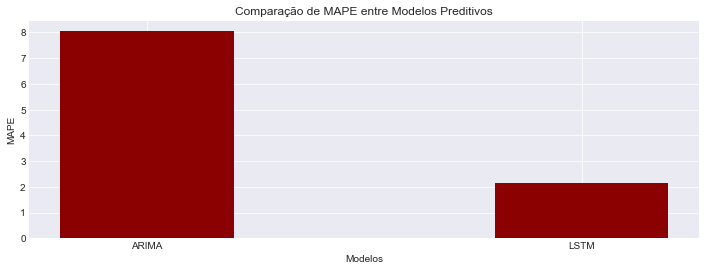

In [125]:
# Criar o gráfico para MAPE
plt.figure(figsize=(12, 4))

# Gráfico exclusivo para MAPE
plt.bar(models, df['MAPE'], color='darkred', width=bar_width)

# Título e legendas
plt.title('Comparação de MAPE entre Modelos Preditivos')
plt.ylabel('MAPE')
plt.xlabel('Modelos')

# Exibir o gráfico
plt.show()

# 8. Conclusão

Os resultados indicam que a LSTM teve um desempenho significativamente melhor que o ARIMA na previsão do índice de fechamento do Ibovespa. O erro médio absoluto (MAE) da LSTM foi de 1.740, enquanto o ARIMA apresentou um valor muito superior, 6.231, evidenciando que a LSTM teve previsões mais precisas.

O erro quadrático médio (MSE) da LSTM foi 4.407, muito inferior ao 56.750 do ARIMA, reforçando a maior eficiência da rede neural em reduzir erros extremos. O erro percentual médio absoluto (MAPE) da LSTM (2.16%) também foi bem menor que o do ARIMA (8.05%), demonstrando que a LSTM foi proporcionalmente mais precisa na previsão dos valores.

O coeficiente de determinação (R²) da LSTM foi 0.866, indicando que o modelo conseguiu explicar bem a variabilidade dos dados. Em contrapartida, o ARIMA obteve um R² negativo (-0.835), o que significa que ele não conseguiu capturar a relação entre as variáveis e teve um desempenho pior do que uma simples média.

Com base nesses resultados, conclui-se que a LSTM é a abordagem mais adequada para prever o índice de fechamento do Ibovespa, pois apresenta menor erro e maior capacidade de explicação dos dados em comparação ao modelo ARIMA.